# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "kenza"
ln1 = "benjelloun"
fn2 = "matthieu"
ln2 = "dubois"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_benjelloun_kenza_and_dubois_matthieu.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

<ipython-input-4-969f29e57d03>:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(coefs)


Text(0.5, 1.0, 'Parameters / Coefficients')

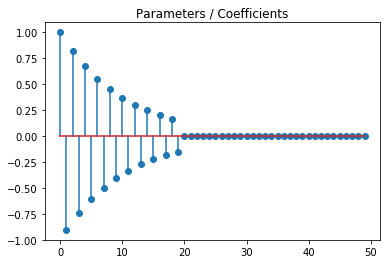

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [6]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [7]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""    
    return np.sign(x) * np.maximum(np.absolute(x) - lmbd,0)

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.linalg.norm(x,ord=1)

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    return x / (lmbd + 1.)

def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd * np.linalg.norm(x,ord=2)**2 / 2


## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

<ipython-input-8-75451d7adea8>:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(x)
<ipython-input-8-75451d7adea8>:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(prox_L1(x, lmbd=l_l1))
<ipython-input-8-75451d7adea8>:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "u

(-2, 2)

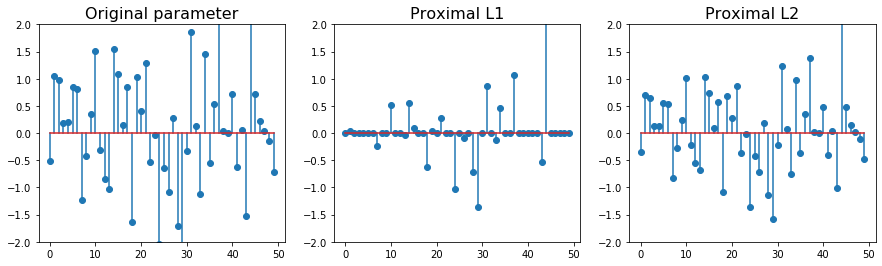

In [8]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>Answer</b>:
     <ul>
      <li> With the l1 method, the values that do not fit the threshold are deleted, leaving only a few of them. This is because the function is non-differentiable.</li>
         <li> With the other one, we are only dividing the values by (1+ $ \lambda $) so they are all left, just reduced. </li>
    </ul>
</div>

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>Answer</b>:
        <ul>
        <li> Linear Regression : $$ \nabla f = - \frac{1}{n} A^{T} (b - Ax) $$
            </li>
        <li> Logistic Regression : $$ \nabla f = \frac{1}{n} \sum^{n}_{i=1} \frac{-b_i a_i exp(- b_i a^T_i x)}{1 + exp(-b_i a^T_i x)} $$
        </ul>

</div>

In [9]:
def loss_linreg(x):
    """Least-squares loss"""
    return (np.linalg.norm(b - A @ x) ** 2) / (2.* n_samples)

def grad_linreg(x):
    """Leas-squares gradient"""
    return - 1./n_samples * A.T @ (b - A @ x)

def loss_logreg(x):
    """Logistic loss"""
    return np.mean(np.log(1+np.exp(-b*(A @ x)))) 


def grad_logreg(x):
    """Logistic gradient"""
    return np.mean(-b* A.T *np.exp(-b*(A @ x))/(1+np.exp(-b*(A @ x))),axis=1)


In [10]:
from scipy.optimize import check_grad
x0 = np.random.randn(n_features)
A, b = simu_linreg(coefs)
print("Check_grad value for Linear Regression:",
      check_grad(loss_linreg,grad_linreg,x0))
A, b = simu_logreg(coefs)
print("Check_grad value for Logistic Regression:",
    check_grad(loss_logreg,grad_logreg,x0))

Check_grad value for Linear Regression: 1.8147447147644627e-06
Check_grad value for Logistic Regression: 1.2115333959504955e-07


The values we get with check_grad are close to 0, so we can safely assume our
calculations are correct.

## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [11]:
# TO BE COMPLETED

# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return np.linalg.norm(A,ord=2)**2 / n_samples
# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    return np.linalg.norm(A,ord=2)**2 / (4*n_samples)
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbda=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbda)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_R(x - step * grad_f(x), step * lmbda)

        
        obj = f(x) + R(x, lmbda)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [12]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbda=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbda)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new = prox_R(z - step * grad_f(z), lmbda * step)
        t_new = (1. + np.sqrt(1. + 4* t**2))/2.
        z = x_new + (t - 1) * (x_new - x) / t_new
        t = t_new
        x = x_new
        

        obj = f(x) + R(x, lmbda)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [13]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [14]:
A, b = simu_linreg(coefs)
min,objectives,errors = APGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2, 1/smoothness_const_linreg(A), lmbd, n_iter=1000, x_true=coefs, verbose=False)

print("minimizer: ", min)
print("minimum: ", loss_linreg(min))


minimizer:  [ 0.95 -0.89  0.81 -0.68  0.58 -0.58  0.52 -0.47  0.44 -0.43  0.37 -0.32
  0.29 -0.25  0.26 -0.21  0.17 -0.16  0.19 -0.17  0.05  0.05 -0.08  0.06
 -0.05 -0.02  0.04 -0.01 -0.04  0.05 -0.01 -0.02  0.02 -0.09  0.04 -0.02
  0.01 -0.04  0.06 -0.05 -0.01 -0.02  0.07 -0.04 -0.04  0.01  0.03  0.06
 -0.04 -0.07]
minimum:  0.45393765897203964


## Linear Regression L1

Text(0.5, 1.0, 'Loss obtained on a linear regression, L1 regularizer')

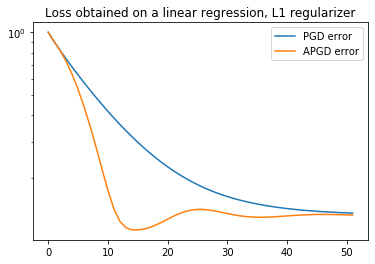

In [15]:
A, b = simu_linreg(coefs)

min_PGD,ob_PGD,er_PGD = PGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

plt.plot(er_PGD)
plt.plot(er_APGD)
plt.yscale('log')
plt.legend(['PGD error', 'APGD error'])
plt.title('Loss obtained on a linear regression, L1 regularizer')

Text(0.5, 1.0, 'Objective values obtained on a linear regression, L1 regularizer')

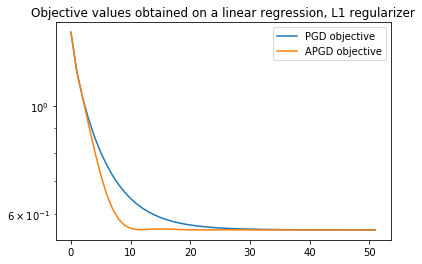

In [16]:
plt.plot(ob_PGD)
plt.plot(ob_APGD)
plt.yscale('log')
plt.legend(['PGD objective', 'APGD objective'])
plt.title('Objective values obtained on a linear regression, L1 regularizer')

## Linear Regression L2

Text(0.5, 1.0, 'Loss obtained on a linear regression, L2 regularizer')

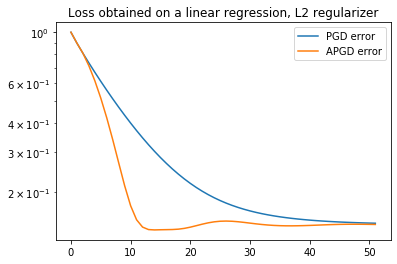

In [17]:
min_PGD,ob_PGD,er_PGD = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

plt.plot(er_PGD)
plt.plot(er_APGD)
plt.yscale('log')
plt.legend(['PGD error', 'APGD error'])
plt.title('Loss obtained on a linear regression, L2 regularizer')

Text(0.5, 1.0, 'Objective values obtained on a linear regression, L2 regularizer')

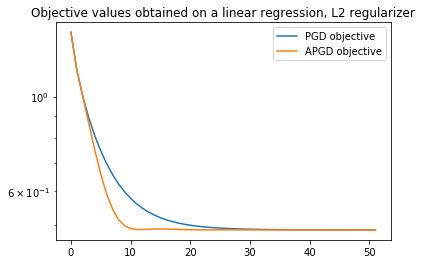

In [18]:
plt.plot(ob_PGD)
plt.plot(ob_APGD)
plt.yscale('log')
plt.legend(['PGD objective', 'APGD objective'])
plt.title('Objective values obtained on a linear regression, L2 regularizer')

## Logistic Regression L1

Text(0.5, 1.0, 'Loss obtained on a logistic regression, L1 regularizer')

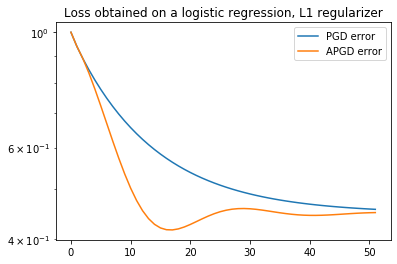

In [19]:
A, b = simu_logreg(coefs)

min_PGD,ob_PGD,er_PGD = PGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1, 1/smoothness_const_loreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_logreg,grad_logreg,L1_norm,prox_L1, 1/smoothness_const_loreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

plt.plot(er_PGD)
plt.plot(er_APGD)
plt.yscale('log')
plt.legend(['PGD error', 'APGD error'])
plt.title('Loss obtained on a logistic regression, L1 regularizer')

Text(0.5, 1.0, 'Objective values obtained on a logistic regression, L1 regularizer')

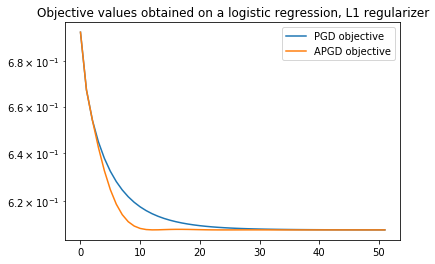

In [20]:
plt.plot(ob_PGD)
plt.plot(ob_APGD)
plt.yscale('log')
plt.legend(['PGD objective', 'APGD objective'])
plt.title('Objective values obtained on a logistic regression, L1 regularizer')

## Logistic Regression L2

Text(0.5, 1.0, 'Loss obtained on a logistic regression, L2 regularizer')

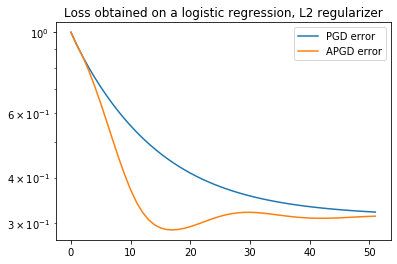

In [21]:
min_PGD,ob_PGD,er_PGD = PGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2, 1/smoothness_const_loreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2, 1/smoothness_const_loreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

plt.plot(er_PGD)
plt.plot(er_APGD)
plt.yscale('log')
plt.legend(['PGD error', 'APGD error'])
plt.title('Loss obtained on a logistic regression, L2 regularizer')

Text(0.5, 1.0, 'Objective values obtained on a logistic regression, L2 regularizer')

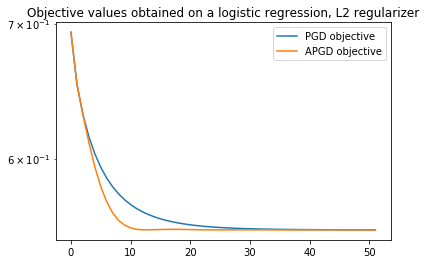

In [22]:
plt.plot(ob_PGD)
plt.plot(ob_APGD)
plt.yscale('log')
plt.legend(['PGD objective', 'APGD objective'])
plt.title('Objective values obtained on a logistic regression, L2 regularizer')

*   It appears from our plots that APGD converges much quicker than PGD for both minimum and minimizer. We can observe a bump in the APGD curve, because of the momentum term added to the gradient.



<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

# Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of the model. 

## L1 regularizer

In [23]:
A, b = simu_linreg(coefs)

min_PGD,ob_PGD,er_PGD = PGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

print("the min obtained with PGD is : " +str(min_PGD))
print("the min obtained with APGD is : " +str(min_APGD))
print("true parameters of the model:" + str(coefs))

print(min_PGD - min_APGD)

the min obtained with PGD is : [ 9.83e-01 -8.72e-01  7.76e-01 -6.94e-01  6.53e-01 -5.58e-01  5.53e-01
 -4.86e-01  3.62e-01 -3.75e-01  3.65e-01 -2.72e-01  1.98e-01 -1.74e-01
  1.86e-01 -1.45e-01  1.48e-01 -1.17e-01  1.14e-01 -7.22e-02 -3.68e-03
 -3.29e-04  4.10e-02 -2.89e-02  0.00e+00 -0.00e+00 -2.02e-02  0.00e+00
 -7.88e-03  0.00e+00  1.96e-02  4.13e-02  9.02e-03  6.52e-02 -1.72e-02
  0.00e+00  3.76e-02 -0.00e+00  0.00e+00  4.94e-02 -1.24e-02 -2.78e-02
 -3.87e-02  1.32e-02  0.00e+00  4.74e-03 -0.00e+00 -6.70e-02  2.74e-02
  2.65e-02]
the min obtained with APGD is : [ 9.84e-01 -8.75e-01  7.80e-01 -6.98e-01  6.57e-01 -5.61e-01  5.56e-01
 -4.88e-01  3.64e-01 -3.78e-01  3.67e-01 -2.74e-01  2.00e-01 -1.76e-01
  1.87e-01 -1.45e-01  1.48e-01 -1.19e-01  1.16e-01 -7.32e-02 -3.38e-03
 -8.61e-04  4.23e-02 -3.00e-02  0.00e+00 -0.00e+00 -2.03e-02  0.00e+00
 -7.96e-03  0.00e+00  1.95e-02  4.11e-02  8.66e-03  6.61e-02 -1.73e-02
  0.00e+00  3.76e-02 -0.00e+00  0.00e+00  4.92e-02 -1.16e-02 -2.88e-02
 -

The solutions of the two methods are almost the same and both are very close to the true values of x, since they are so similar, we will only compare  the values obtained with APGD (the closest ones) to the true coefs. 

<ipython-input-24-1dfe87c783b2>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemlines, baseline = plt.stem(coefs,label='True coefs')
<ipython-input-24-1dfe87c783b2>:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemlines, baseline = plt.stem(min_APGD,label='Solution of APGD methods')


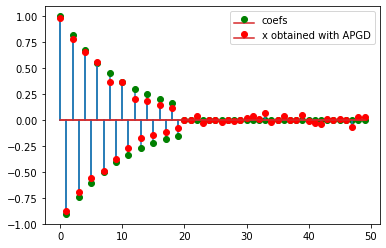

In [24]:
markerline, stemlines, baseline = plt.stem(coefs,label='True coefs')
plt.setp(markerline, color='g')

markerline, stemlines, baseline = plt.stem(min_APGD,label='Solution of APGD methods')
plt.setp(markerline, color='r')


plt.legend(['coefs', 'x obtained with APGD'])

plt.show()

## L2 regularizer


In [25]:
A, b = simu_linreg(coefs)

min_PGD,ob_PGD,er_PGD = PGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

min_APGD,ob_APGD,er_APGD = APGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

print("the min obtained with PGD is : " +str(min_PGD))
print("the min obtained with APGD is : " +str(min_APGD))
print("true parameters of the model:" + str(coefs))
print(min_PGD - min_APGD)

the min obtained with PGD is : [ 9.66e-01 -9.04e-01  8.71e-01 -7.65e-01  5.95e-01 -5.75e-01  5.59e-01
 -5.34e-01  4.34e-01 -4.25e-01  2.91e-01 -2.68e-01  2.77e-01 -2.47e-01
  2.56e-01 -2.27e-01  1.16e-01 -8.87e-02  1.10e-01 -1.64e-01  5.19e-04
 -2.51e-02  4.81e-02 -4.32e-02  6.49e-02 -2.88e-02  4.66e-02  2.58e-03
 -4.44e-02  1.10e-02  1.97e-02 -1.57e-02  7.77e-02 -2.46e-02 -1.37e-03
  2.97e-03 -4.39e-02 -1.26e-02  1.73e-02  1.68e-02  3.01e-02 -1.58e-03
  2.79e-02 -1.96e-02 -1.39e-02 -8.78e-03 -2.81e-02 -2.29e-03 -3.35e-02
 -2.85e-02]
the min obtained with APGD is : [ 9.67e-01 -9.06e-01  8.74e-01 -7.68e-01  5.98e-01 -5.77e-01  5.62e-01
 -5.36e-01  4.36e-01 -4.27e-01  2.92e-01 -2.69e-01  2.80e-01 -2.49e-01
  2.56e-01 -2.27e-01  1.16e-01 -8.96e-02  1.10e-01 -1.64e-01  6.51e-04
 -2.59e-02  4.90e-02 -4.38e-02  6.56e-02 -2.88e-02  4.63e-02  1.88e-03
 -4.34e-02  1.01e-02  2.00e-02 -1.51e-02  7.71e-02 -2.48e-02 -1.70e-03
  3.55e-03 -4.46e-02 -1.27e-02  1.88e-02  1.53e-02  3.07e-02 -2.67e-03
  

Once again, the values obtained with both methods are very close to each other. As we did before, we will only compare the APGD values to the true ones.

<ipython-input-26-9bd6b9cf7e91>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemlines, baseline = plt.stem(coefs,label='True coefs')
<ipython-input-26-9bd6b9cf7e91>:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  markerline, stemlines, baseline = plt.stem(min_APGD,label='Solution of APGD methods')


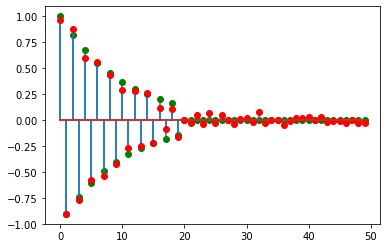

In [26]:
markerline, stemlines, baseline = plt.stem(coefs,label='True coefs')
plt.setp(markerline, color='g')

markerline, stemlines, baseline = plt.stem(min_APGD,label='Solution of APGD methods')
plt.setp(markerline, color='r')

plt.show()

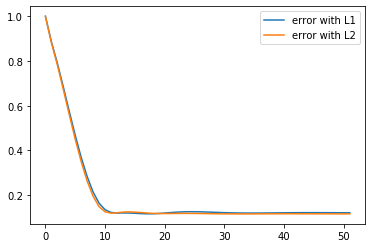

In [27]:
min_APGD_L1,ob_APGD_L1,er_APGD_L1 = APGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

min_APGD_L2,ob_APGD_L2,er_APGD_L2 = APGD(x0,loss_linreg,grad_linreg,L2_norm,prox_L2, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)

plt.plot(er_APGD_L1)
plt.plot(er_APGD_L2)
plt.legend(['error with L1', 'error with L2'])

When looking at the error obtained with both regularizer, in the case of linear regression, we can see that L1 yields slightly better results. But overall the difference is barely noticeable. It seems that setting some coefficients to zero fits the problem of linear regression.

#  Influence of the correlation of the features on the performance of the optimization algorithms for linear problem and L1 regularizer 

Text(0.5, 1.0, 'PGD error with different values of correlation on a linear regression model')

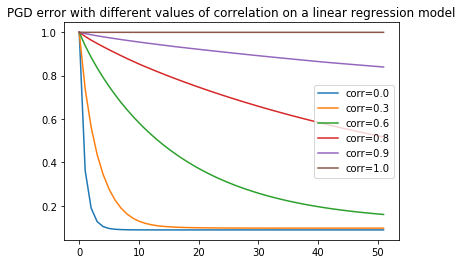

In [28]:
for corr in [0.,0.3,0.6,0.8,0.9,1.0]:
  A, b = simu_linreg(coefs, corr=corr)

  min_PGD,ob_PGD,er_PGD = PGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)
  plt.plot(er_PGD, label='corr='+ str(corr))
  plt.legend()
plt.title("PGD error with different values of correlation on a linear regression model")

Text(0.5, 1.0, 'PGD error with different values of correlation on a linear regression model')

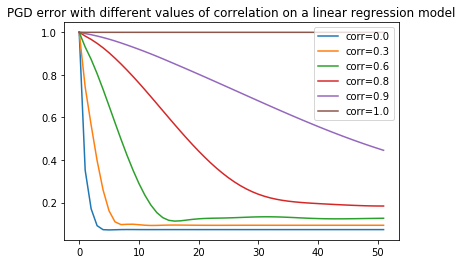

In [29]:
for corr in [0.,0.3,0.6,0.8,0.9,1.0]:
  A, b = simu_linreg(coefs, corr=corr)

  min_APGD,ob_APGD,er_APGD = APGD(x0,loss_linreg,grad_linreg,L1_norm,prox_L1, 1/smoothness_const_linreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)
  plt.plot(er_APGD, label='corr='+ str(corr))
  plt.legend()
plt.title("PGD error with different values of correlation on a linear regression model")

For both APGD and PGD, as the correlation of the features increase, the algorithm has more difficulty reaching the true coefficients of the model. The closer our features are, the harder it becomes to differentiate betweeen datapoints. That means that rescaling data helps with learning the parameters.

# influence of the level of penalization ( λ ) on the performance of the optimization algorithms with logistic problem and L2 penalization


Text(0.5, 1.0, 'Error given by a PGD algorihm with different values of lambda')

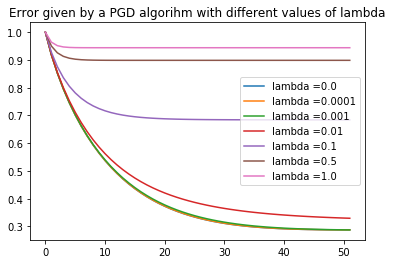

In [30]:
A, b = simu_logreg(coefs)
for lmbd in [0.,0.0001,0.001,0.01,0.1,0.5,1.]:
  min_PGD,ob_PGD,er_PGD = PGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2, 1/smoothness_const_loreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)
  plt.plot(er_PGD, label='lambda ='+str(lmbd))
  plt.legend()
plt.title('Error given by a PGD algorihm with different values of lambda')

Text(0.5, 1.0, 'Error given by a APGD algorihm with different values of lambda')

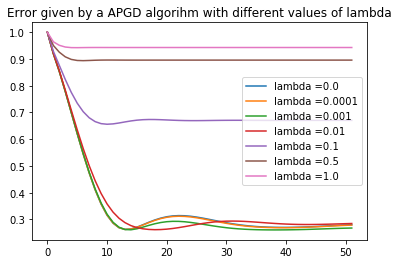

In [31]:
A, b = simu_logreg(coefs)
for lmbd in [0.,0.0001,0.001,0.01,0.1,0.5,1.]:
  min_APGD,ob_APGD,er_APGD = APGD(x0,loss_logreg,grad_logreg,L2_norm,prox_L2, 1/smoothness_const_loreg(A), lmbd, n_iter=50, x_true=coefs, verbose=False)
  plt.plot(er_APGD, label='lambda ='+str(lmbd))
  plt.legend()
plt.title('Error given by a APGD algorihm with different values of lambda')

When λ gets larger in value, the algorithm has more difficulty reaching the true coefficients of our model. In our case, at λ = 0.1 we have terrible results. Hence why we can say that our algorithms work better when λ is small.
A reason for this might be that when λ is too large the regularization term becomes too important for our optimizer. 